## Introduction
Car Model Classification
차 종(모델)의 분류는 일반적인 이미지 분류 예측 보다는 난이도가 있습니다. 예를 들어, 우리가 강아지와 사람을 분류 예측 해야 한다고 가정해봅시다. 사람의 이미지와 강아지의 이미지를 서로 비교해서 보면, 사람에게 드러나는 특징과 강아지에게 드러나는 특징은 비교적 차이가 존재합니다.

하지만, 자동차라는 하나의 카테고리의 이미지들 가운데, 심지어는 브랜드마저 같은 차량이 존재하는 이미지들 사이에서 차량의 모델을 분류하는 작업은 강아지와 사람을 구분하는 것 처럼 간단히 할 수 있는 문제가 아닙니다.

## Competition
이번 컴페티션에서는, 주어진 자동차 이미지를 총 196개의 클래스로 분류 예측하는 것이 목표입니다.
sample_submission에 매핑된 테스트 이미지의 클래스를 예측하여 제출하시면 됩니다.

## Load library
기본적인 라이브러리를 로드 합니다.

In [1]:
import gc
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 혹 다른 데이터 셋 추가(Pretrained Model Weights)로 인해 PATH가 변경된다면 아래 PATH를 수정
DATA_PATH = './drive/MyDrive/강의및특강/2024_메디컬IoT/input'
os.listdir(DATA_PATH)

['class.csv', 'train.csv', 'train']

##Data Description에 있는 파일 세부 정보입니다.

train.csv - Train 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
test.csv - Test 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
submission.csv - Test셋과 대응되는 제출 파일
class.csv - 데이터 셋의 class 컬럼과 대응되는 차종의 레이블
train - Train 이미지 파일
test - Test 이미지 파일

In [3]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
#TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
#df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

## Data Exploration
실제 데이터가 Description과 일치 하는지, 데이터는 어떻게 구성되어 있고 클래스 별로 어떤 분포를 가지고 있는지 등 데이터에 대한 전반적인 궁금증을 해결해보는 과정입니다.

##Check Data
Data Description에 나와 있는 컬럼 별 세부 설명 입니다.


*   img_file - 데이터 셋의 각 로우와 연결되는 이미지 파일 이름
*   bbox_x1 - 바운딩 박스 x1 좌표 (좌상단 x)
*   bbox_y1 - 바운딩 박스 y1 좌표 (좌상단 y)
*   bbox_x2 - 바운딩 박스 x2 좌표 (우하단 x)
*   bbox_y2 - 바운딩 박스 y2 좌표 (우하단 y)
*   class - 예측하려는 차종(Target)
*   id - 각 데이터 셋에 기입 되어 있는 클래스 id
*   name - 클래스 id에 대응되는 실제 차종 레이블

In [4]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [6]:
# Data 누락 체크
if set(list(df_train.img_file)) == set(os.listdir(TRAIN_IMG_PATH)) :
    print("Train file 누락 없음!")
else :
    print("Train file 누락")

#if set(list(df_test.img_file)) == set(os.listdir(TEST_IMG_PATH)) :
#    print("Test file 누락 없음!")
#else :
#    print("Test file 누락")

Train file 누락 없음!


In [7]:
# Data 갯수
print("Number of Train Data : {}".format(df_train.shape[0]))
#print("Number of Test Data : {}".format(df_test.shape[0]))

Number of Train Data : 2000


In [8]:
df_class.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


In [9]:
print("타겟 클래스 총 갯수 : {}".format(df_class.shape[0]))
print("Train Data의 타겟 종류 갯수 : {}".format(df_train['class'].nunique()))

타겟 클래스 총 갯수 : 196
Train Data의 타겟 종류 갯수 : 196


In [11]:
df_train.value_counts('class')

,count
class,
65,19
8,18
110,17
80,16
30,16
...,...
158,5
159,5
175,5


## Class Distribution
분류 문제에서 가장 먼저 의심해봐야 할 부분이 바로 Target Class의 분포입니다. 학습에 사용해야 하는 Train Set의 타겟 분포를 확인해서 밸런스가 어느정도인지 체크해야 합니다.

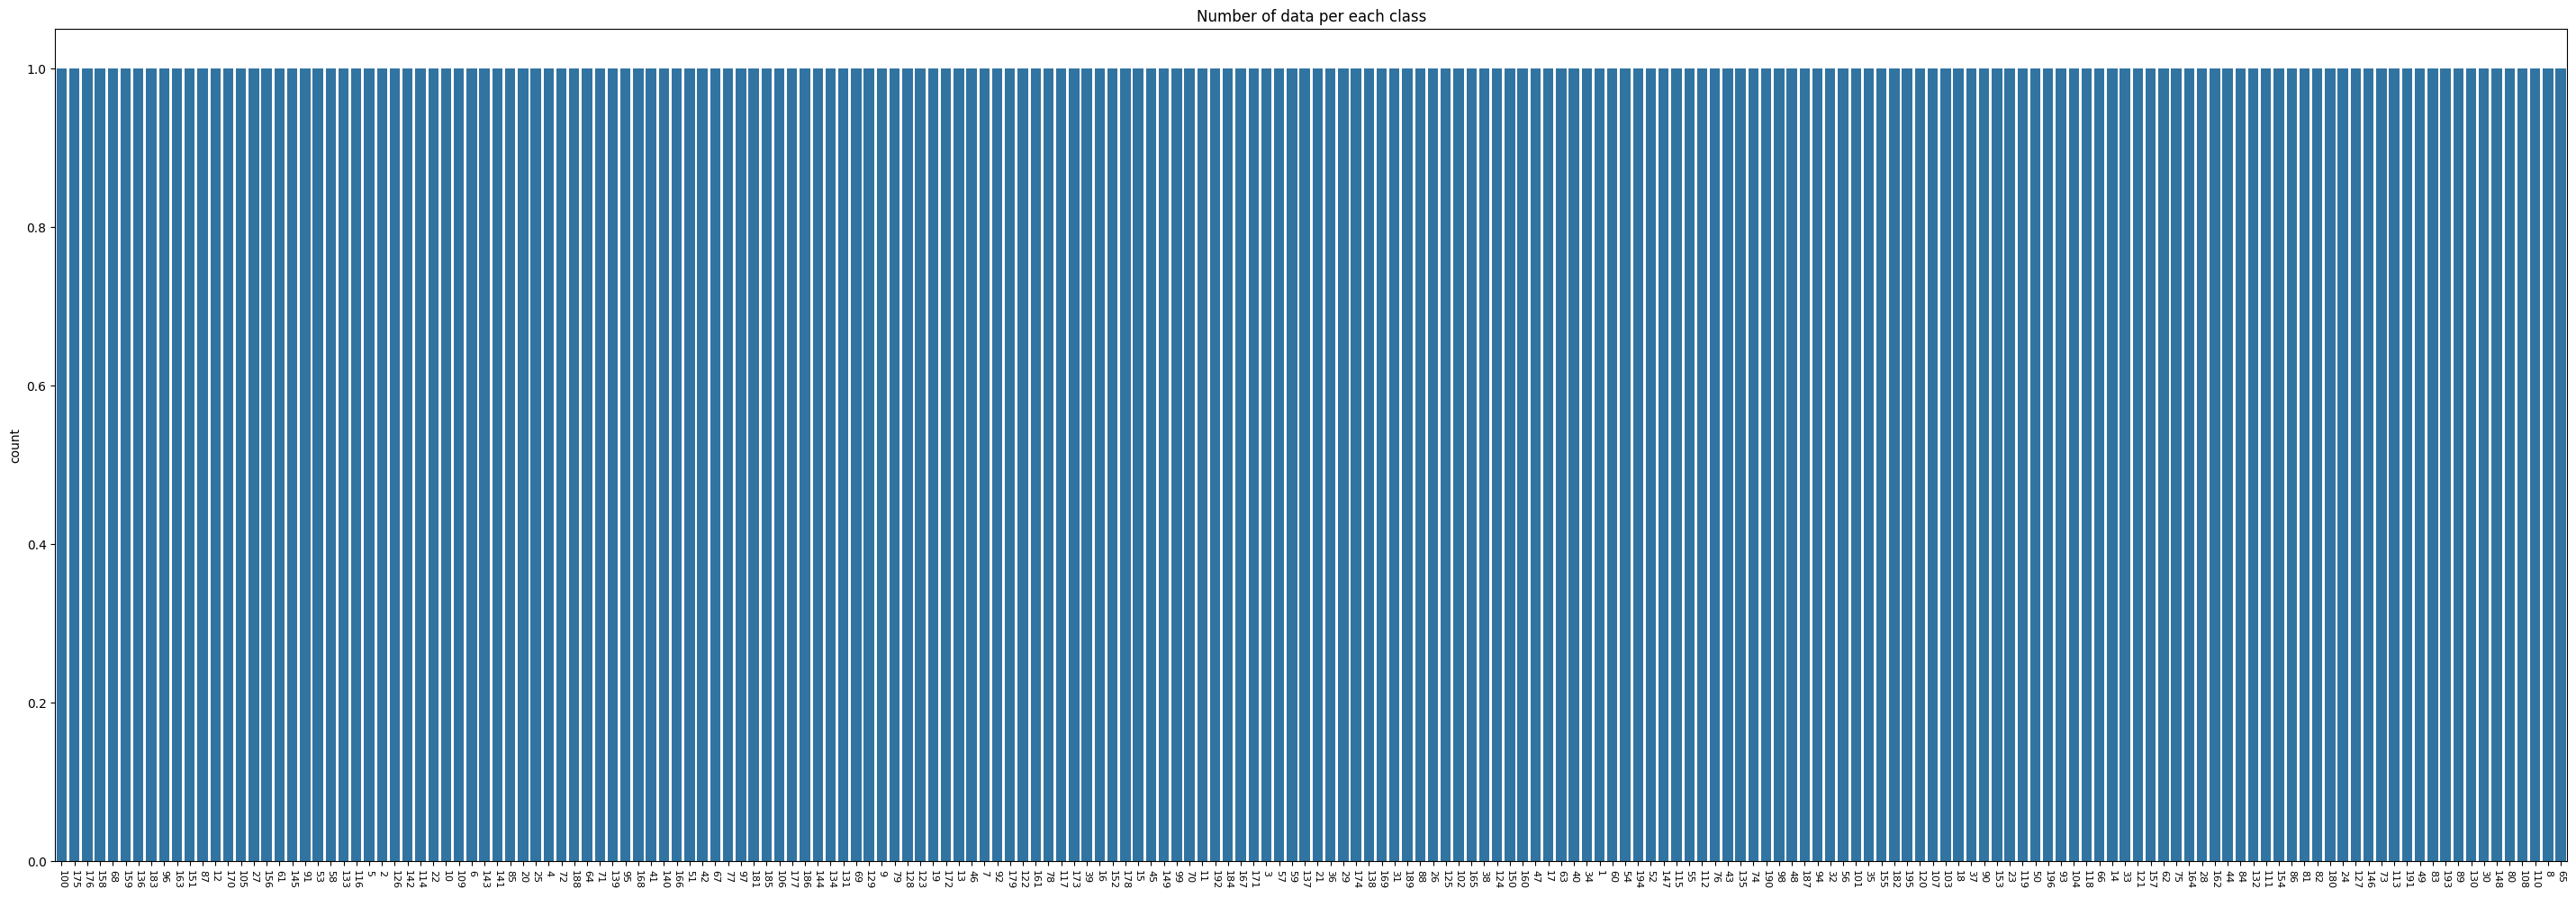

In [15]:
plt.figure(figsize=(36, 12))
plt.xticks(rotation=270, fontsize=8)
sns.countplot(df_train["class"], order=df_train["class"].value_counts(ascending=True).index)
plt.title("Number of data per each class")
plt.show()

In [16]:
cntEachClass = df_train["class"].value_counts(ascending=False)
print("Class with most count  : {}".format(cntEachClass.index[0]))
print("Most Count : {}".format(cntEachClass.max()))

print("Class with fewest count  : {}".format(cntEachClass.index[-1]))
print("Fewest Count : {}".format(cntEachClass.min()))

print("Mean  : {}".format(cntEachClass.mean()))

Class with most count  : 65
Most Count : 19
Class with fewest count  : 100
Fewest Count : 3
Mean  : 10.204081632653061


In [17]:
cntEachClass.describe()

,count
count,196.000000
mean,10.204082
std,2.806436
min,3.000000
25%,8.000000
50%,10.000000
75%,12.000000
max,19.000000


## Image Visualization
파이썬 커널에서 이미지를 보고 싶을땐 어떻게 할까요? 이미지를 로드하는 방법은 여러 방법이 있지만, 이 커널에서는 PIL 라이브러리를 사용합니다.
Documentation : https://pillow.readthedocs.io/en/stable/

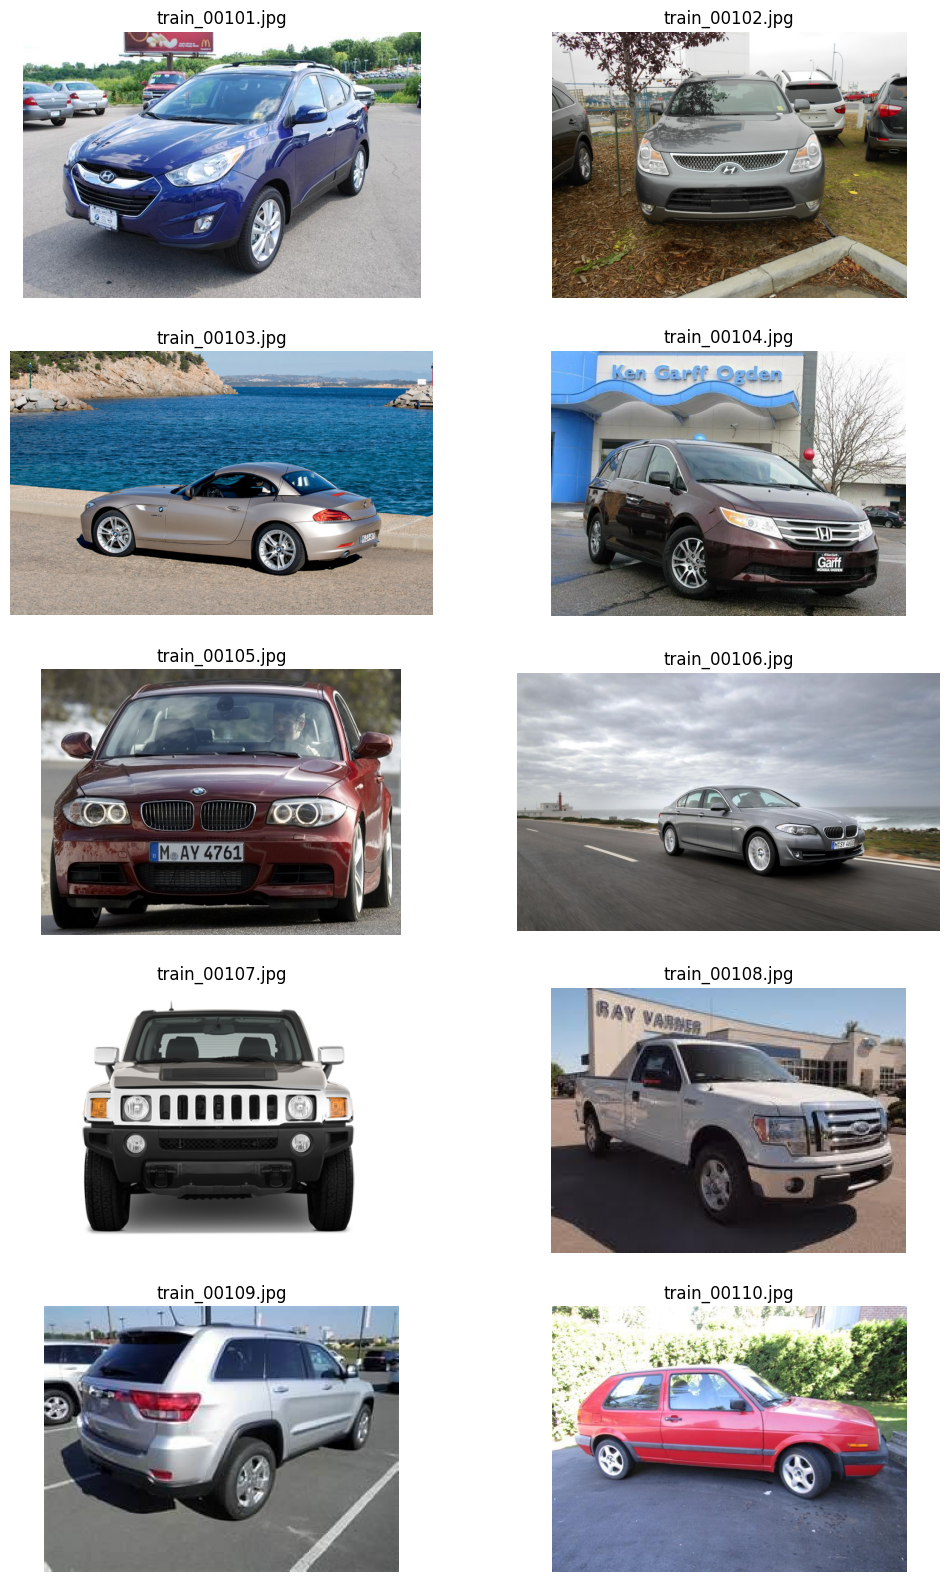

In [18]:
import PIL
from PIL import ImageDraw

tmp_imgs = df_train['img_file'][100:110]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 2, num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')

## Bounding Box
바운딩 박스란?
이미지 내부에서 특정 Object를 박스로 레이블한 좌표를 말하며, 보통 좌측 상단 (x1, y1)과, 우측 하단 (x2, y2) 좌표가 주어져서
직사각형 모양의 박스를 그릴 수 있게됩니다. 이때, 좌표는 이미지의 픽셀 좌표입니다.

In [80]:
def draw_rect(drawcontext, pos, outline=None, width=0):
    (x1, y1) = (pos[0], pos[1])
    (x2, y2) = (pos[2], pos[3])
    points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    drawcontext.line(points, fill=outline, width=width)

def make_boxing_img(img_name) :
    if img_name.split('_')[0] == "train" :
        PATH = TRAIN_IMG_PATH
        data = df_train

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    draw = ImageDraw.Draw(img)
    draw_rect(draw, pos, outline='red', width=10)

    return img

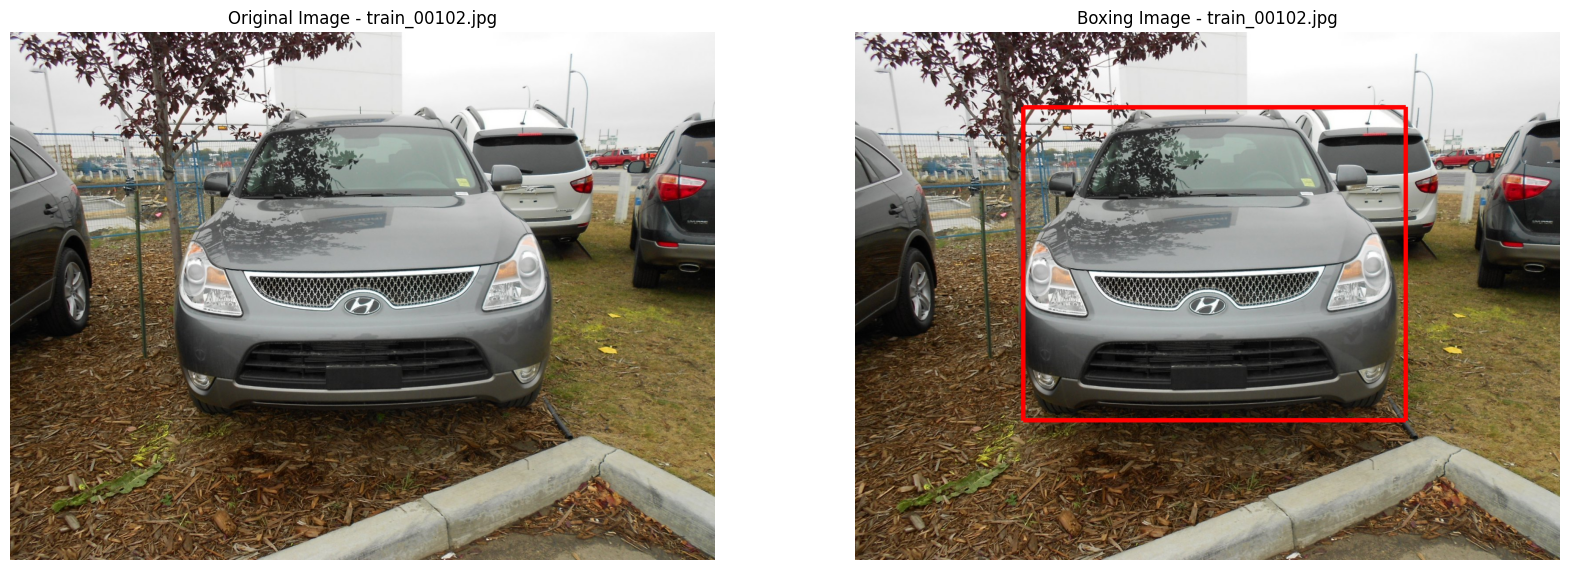

In [20]:
f_name = "train_00102.jpg"

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
# Original Image
origin_img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

# Image included bounding box
plt.subplot(1, 2, 2)
boxing = make_boxing_img(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

plt.show()

왼쪽 그림과 같이 어떤 이미지에는 내가 필요로하는 Target Object 뿐만 아니라 상관 없는 다른 Object(Noise)가 섞여 있을 수 있습니다. 이런 경우에 이미지 내부에서 필요한 Object를 명확히 표시하기 위해 Bounding Box를 사용합니다.
(실제로 이미지를 모델에 넣을때는 Box 바깥 부분은 잘라서 사용합니다.)

이번 컴페티션은 Bounding Box 좌표가 이미 주어져 있습니다. 만약 Bounding Box 좌표가 주어지지 않는다면 어떻게 해야 할까요? 이런 경우에는 직접 레이블을 하거나, Bounding Box를 좌표를 예측하는 딥러닝 모델을 설계해볼 수도 있습니다.

이번 커널에서는 바운딩박스를 활용하지 않습니다. 하지만, 꼭 구현해보시길 권장합니다.

In [93]:
import cv2
folder_dir = DATA_PATH+'/train'

Total_img = []
for i in (os.listdir(folder_dir)):
    file_dir = folder_dir+'/'+i
    img = cv2.imread(file_dir, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))
    Total_img.append(img)

Total_img = np.array(Total_img)
print(Total_img.shape)

(2000, 224, 224, 3)
2000


In [96]:
from sklearn.model_selection import train_test_split

df_train["class"] = df_train["class"].astype('str')
df_train = df_train[['img_file', 'class']]
X = Total_img
y = df_train['class']
y = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.95, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1900, 224, 224, 3) (1900, 196)
(100, 224, 224, 3) (100, 196)


## ResNet50
### ResNet arxiv : http://www.arxiv.org/abs/1512.03385

In [111]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input

# Define the input shape explicitly
input_tensor = Input(shape=(224, 224, 3))

# Instantiate the ResNet50 model with the input tensor
resNet_model = ResNet50(include_top=False, input_tensor=input_tensor)

# Use the Functional API to build the rest of the model
x = resNet_model.output  # Get the output of ResNet50
x = GlobalAveragePooling2D()(x)  # Apply GlobalAveragePooling2D
output = Dense(196, activation='softmax', kernel_initializer='he_normal')(x)  # Add the final Dense layer

# Create the final model
model = Model(inputs=resNet_model.input, outputs=output)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,989,316 (91.51 MB)

 Trainable params: 23,936,196 (91.31 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Model Compile
이제 Model을 만들었으니 어떻게 학습할 지 정해야 합니다. 어떤 방법으로, 어떤 속도로, 어떤 지표를 기준으로 등등 정할 수 있고 필요시에는 각각의 함수를 직접 구현해볼 수도 있습니다. 하지만, 보통은 기본으로 주어지는 것들을 사용합니다.

In [112]:
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

##Model Training
이제 진짜로 학습을 해봅시다. 학습에는 시간이 조금 걸리니 커피라도 한 잔 하시는게 어떨까요?

In [113]:
# Parameter
epochs = 20
batch_size = 32

# Model Config
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath = "/my_resnet_model_{val_acc:.2f}_{val_loss:.4f}.h5"

# ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

callbackList = [es]

# Use model.fit instead of model.fit_generator
history = model.fit(X_train, y_train,
                    batch_size=batch_size, epochs=epochs,
                    validation_split=0.2)
gc.collect()
model.save(DATA_PATH+filepath)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 102s 911ms/step - acc: 0.0046 - loss: 5.8540 - val_acc: 0.0026 - val_loss: 98.9503
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 299ms/step - acc: 0.0061 - loss: 5.3093 - val_acc: 0.0026 - val_loss: 794.9100
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/step - acc: 0.0169 - loss: 5.2011 - val_acc: 0.0079 - val_loss: 383.2718
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 297ms/step - acc: 0.0196 - loss: 5.1289 - val_acc: 0.0079 - val_loss: 7.8563
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 297ms/step - acc: 0.0337 - loss: 4.9190 - val_acc: 0.0000e+00 - val_loss: 14.3788
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 291ms/step - acc: 0.0545 - loss: 4.6883 - val_acc: 0.0026 - val_loss: 6.5544
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 292ms/step - acc: 0.1203 - loss: 4.2937 - val_acc: 0.0000e+00 - val_loss: 11.3140
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 290ms/step - acc: 0.1641 - loss: 3.8472 - val_acc: 0.0026 - val_loss: 8.0243
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━

##Training History Visualization
학습된 결과를 plot으로 그려볼 수 있습니다. 모델 학습 로그를 통해서 확인할 수도 있지만, 전반적인 학습 형태를 한눈에 파악하기에는 그래프만 한 것이 없습니다.

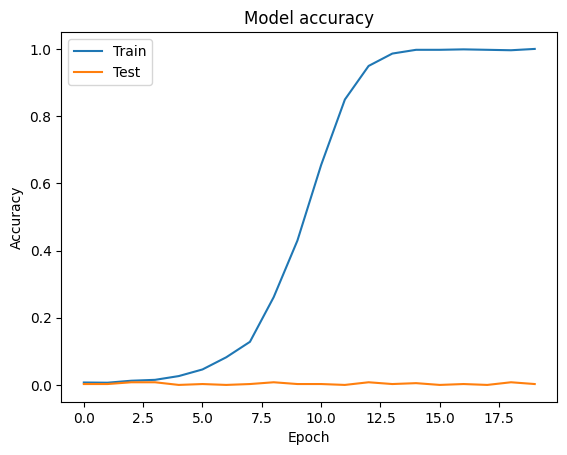

In [114]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Predict & Make submission
겨우 모델 학습이 끝났군요! 하지만, 아직 끝나지 않았습니다. 모델이 테스트 데이터에도 잘 적용되는지 predict를 해야 합니다.

In [123]:
prediction = model.predict(X_test)
y_pred = np.argmax(prediction, axis=1)
print(y_pred,'\n')

y_test = np.argmax(y_test, axis=1)
print(y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
[110 108  59 184 153 135 162 125 132  76 166  74 157   7   1 192  37  63
  99 174  36 140 140  64 116  20  78 125 167 158 106  89  78  11 108  13
 101 156  95 180  60 119 161 117 122  58  76 184  46  70   0 109 192 123
 169  70 121   9 136  67 123  65 134  19  15  67  49 117 189  45  10 142
 126 158 113  56 119  43  45 104 110   8   0  47   9 108  63  45 119  96
  19  29 101 125 177  95  10 135 183 119] 

[ 83 140  72 104 177  75  11  29  34  92  53 173  72  56 158  18 174 103
  18 159  17 134 181 135 118   6 180  21 186 120 169  92  64  55  91  79
  38 148  36 139 134  14 107 153  79  48  72 166  72  23  50  47 102 170
 138  80 121  22 112 110 185 185   5  36 123 138  70 136  60 175 121  60
 127  60  13 176   6  61 167 195   7 193 181 114  70 175 178 107 125  34
 191  77 173  33 142  39  15  97  92  13]


In [125]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         2
          19       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         1
          22       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_